### Document Deskewing

In this notebook we demonstrate how to use image gradients to correct the orientation of scanned documents, the so called document deskewing. The process consists of the following steps:
* Gradient estimation. Since the final text shall be horizontal we are insterested in vertical gradients only.
* Hough transform to find the predominant lines. Here is is aassumed that the text on the (correctly oriented) page is mostly horizontal.
* Estimation of the rotation angle and deskewing (orientation correction).

In [1]:
import cv2
import numpy as np
from math import degrees
from skimage import io

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

(<Axes: title={'center': 'Vertical gradient'}>,
 Text(0.5, 1.0, 'Vertical gradient'))

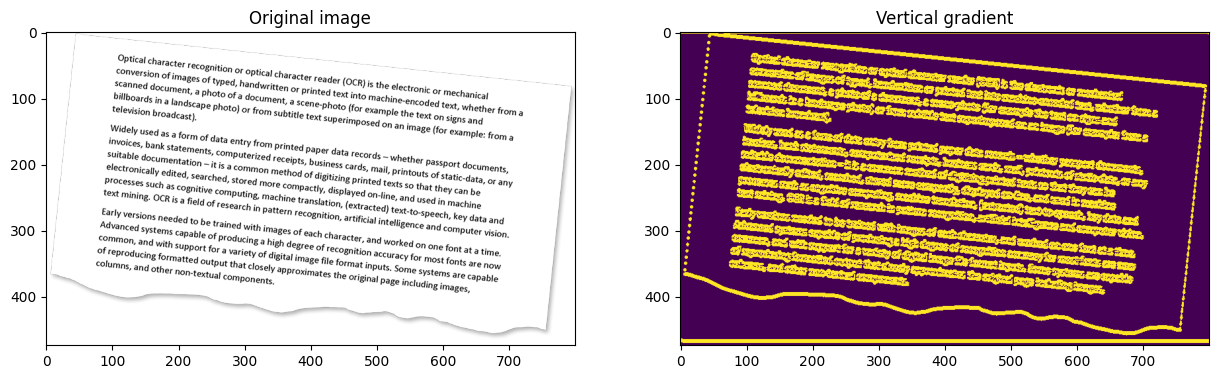

In [2]:
# Read image
# image = io.imread('https://www.highmotionsoftware.com/images/imbatch/imbatch_deskew3_sample1.jpg')
image = io.imread('https://docs.aspose.cloud/ocr/deskew-image/skew-origin.png')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Sobel operator to detect horizontal edges (text lines)
# We use Sobel in y-direction to detect horizontal text lines
sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)

# Convert to absolute values and scale to 8-bit
abs_sobel_y = cv2.convertScaleAbs(sobely)

# Threshold to get binary image highlighting text lines
_, thresh = cv2.threshold(abs_sobel_y, 30, 255, cv2.THRESH_BINARY)

plt.subplot(121), plt.imshow(image), plt.title('Original image')
plt.subplot(122), plt.imshow(thresh), plt.title('Vertical gradient')

### Document Deskewing

We now have two options of how to compute the Hough transform. Either we use the original definition using the HoughLines function or we use the probabilistic approximation using the HoughLinesP. The probabilistic approximation is, in general, faster and more robust to non-linearities. Unlike the classic Hough transform, it also outputs the segment extreme points.

Let's start with the HoughTransform function first.

In [3]:
# Use standard Hough transform to detect lines
lines = cv2.HoughLines(thresh, 1, np.pi/180, 300)

# Calculate angles of detected lines and use the strongest lines to compute their slope
angles = []
if lines is not None:
    for line in lines[0:int(0.1*len(lines))]:
        rho, theta = line[0]
        # Convert theta to degrees
        angle_deg = degrees(theta) - 90  # Adjust to get the text line angle
        
        # We only care about nearly horizontal lines (text)
        # Standard HoughLines returns angles in [0, 180), so we need to adjust
        if abs(angle_deg) < 20 or abs(angle_deg - 180) < 20 or abs(angle_deg + 180) < 20:
            # Normalize angles
            if angle_deg > 90:
                angle_deg -= 180
            elif angle_deg < -90:
                angle_deg += 180
                
            angles.append(angle_deg)

(Text(0, 0.5, 'Line slopes (deg)'),
 Text(0.5, 1.0, 'Estimated slopes of the detected lines'))

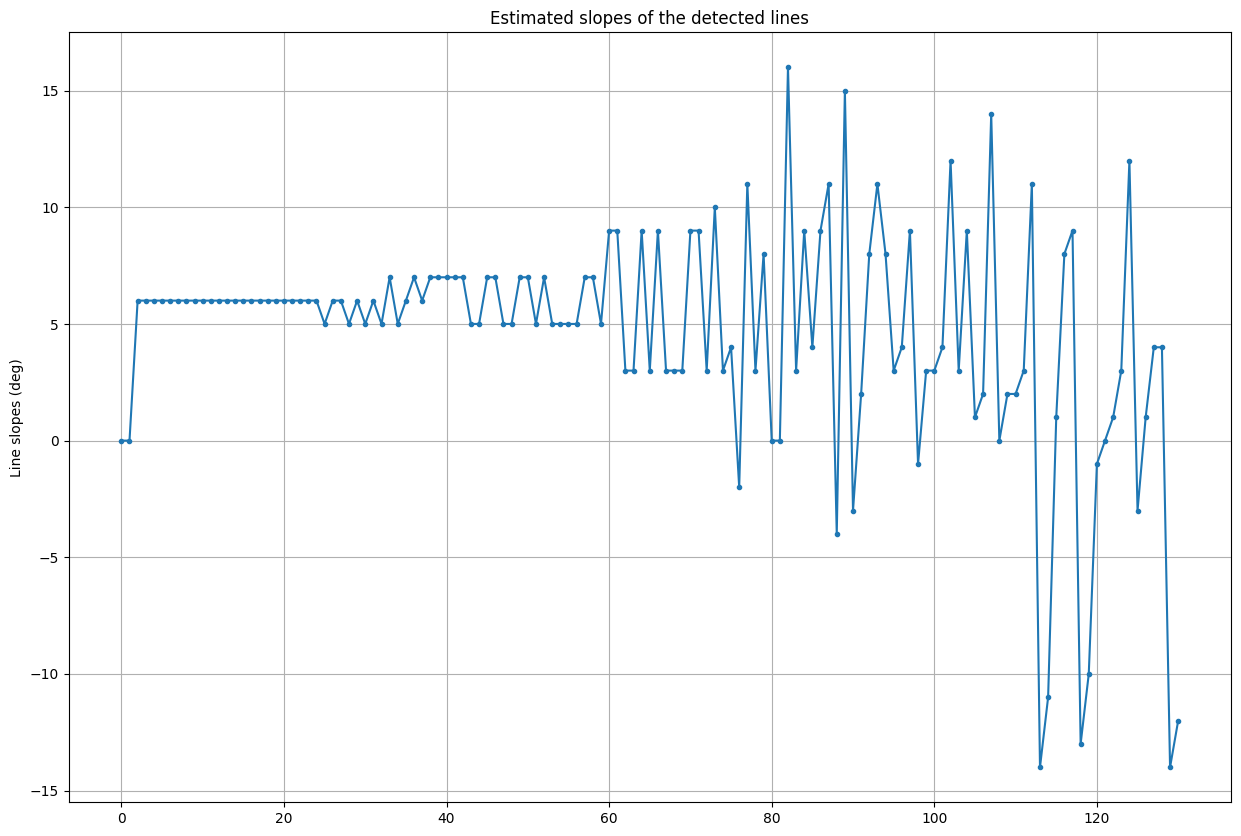

In [4]:
plt.plot(angles, '.-'), plt.grid(True)
plt.ylabel('Line slopes (deg)'), plt.title('Estimated slopes of the detected lines')

Let us now repeat the process with the probabilistic approximation for the Hough transform.

In [5]:
# Use Hough transform to detect lines
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 100, minLineLength=100, maxLineGap=10)

# Calculate angles of detected lines
angles_p = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # Avoid division by zero
        if x2 - x1 == 0:
            continue
        angle = np.arctan2(y2 - y1, x2 - x1)
        # Convert to degrees and adjust to get skew angle
        angle_deg = degrees(angle)
        # We only care about nearly horizontal lines (text)
        if abs(angle_deg) < 50:
            angles_p.append(angle_deg)

(Text(0, 0.5, 'Line slopes (deg)'),
 Text(0.5, 1.0, 'Estimated slopes of the detected lines (prob)'))

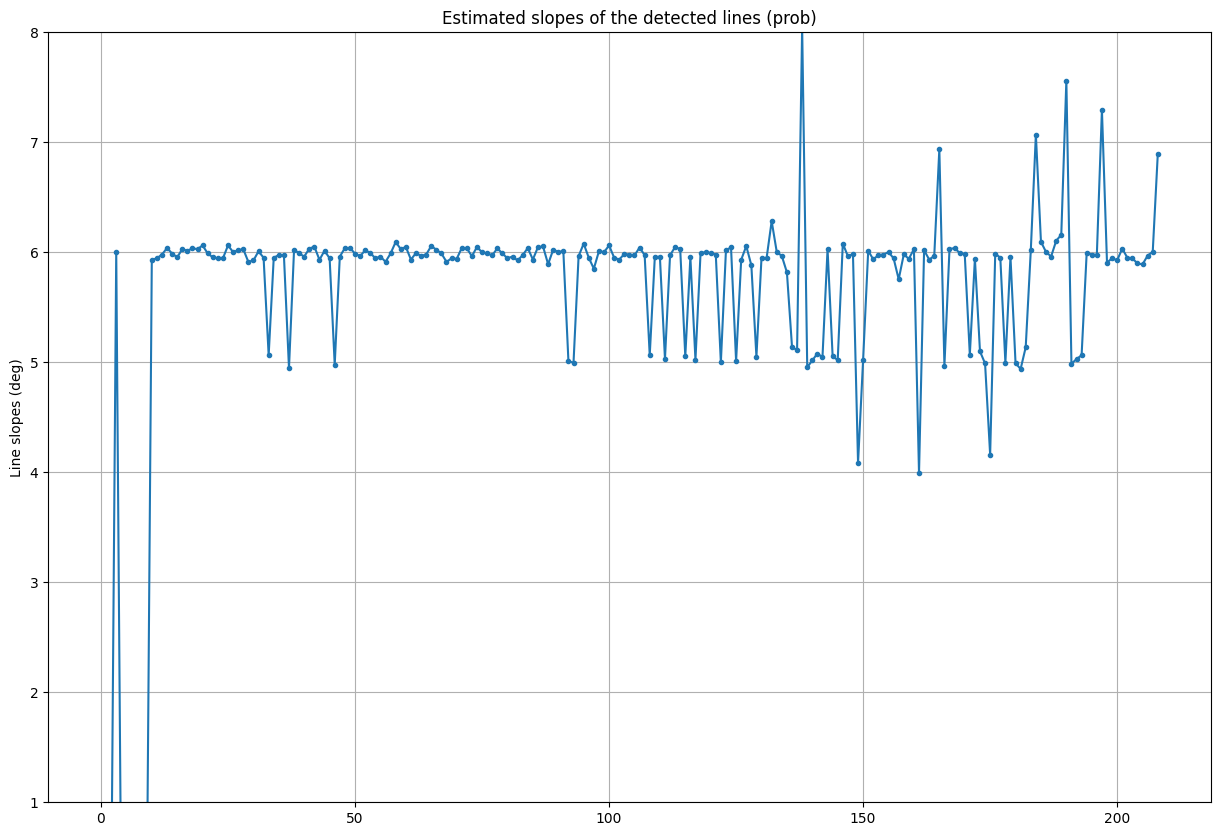

In [6]:
plt.plot(angles_p, '.-'), plt.ylim([1, 8]), plt.grid(True)
plt.ylabel('Line slopes (deg)'), plt.title('Estimated slopes of the detected lines (prob)')

We now compute the median slope value for both cases and apply image rotation to correct the orientation. Don't worry if you don't know how image rotation works, we will cover the geometric transformations later in this course.

In [7]:
# Calculate average skew angle
skew_angle = np.median(angles)
skew_angle_p = np.median(angles_p)


# Get image dimensions
height, width = image.shape[:2]
center = (width // 2, height // 2)

# Create rotation matrix
M = cv2.getRotationMatrix2D(center, skew_angle, 1.0)
M_p = cv2.getRotationMatrix2D(center, skew_angle_p, 1.0)

# Apply rotation
rotated = cv2.warpAffine(image, M, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
rotated_p = cv2.warpAffine(image, M_p, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

print(f"Detected skew angle:        {skew_angle:.2f} degrees")
print(f"Detected skew angle (prob): {skew_angle_p:.2f} degrees")

Detected skew angle:        6.00 degrees
Detected skew angle (prob): 5.97 degrees


(<Axes: title={'center': 'Corrected via HoughTransformP'}>,
 Text(0.5, 1.0, 'Corrected via HoughTransformP'))

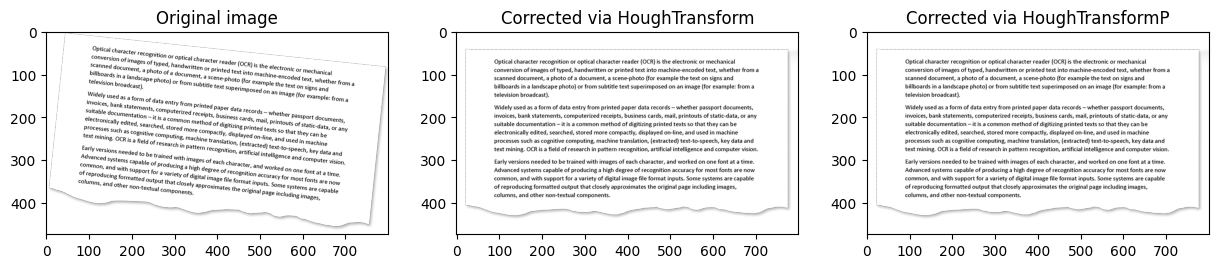

In [8]:
plt.subplot(131), plt.imshow(image), plt.title('Original image')
plt.subplot(132), plt.imshow(rotated), plt.title('Corrected via HoughTransform')
plt.subplot(133), plt.imshow(rotated_p), plt.title('Corrected via HoughTransformP')